# Child Mind Institute - Detect Sleep States
## Feature Engineering

### Load libraries

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Load data

In [55]:
df = pd.read_csv('../data/featured_train_series.csv')

### Descriptive statistics

In [56]:
df.describe()

,step,anglez,enmo,event,time_of_day_sin,time_of_day_cos,series_anglez_mean,series_anglez_median,series_anglez_std,series_anglez_count,...,series_anglez_vc_greater_1,series_anglez_vc_greater_0,series_enmo_vc_greater_1,series_enmo_vc_greater_0,anglez_enmo_product,anglez_enmo_ratio,anglez_change_point,enmo_change_point,series_anglez_unique_count,series_enmo_unique_count
count,9.908080e+05,990808.000000,990808.000000,990808.000000,9.908080e+05,9.908080e+05,990808.000000,990808.000000,990808.000000,990808.000000,...,990808.000000,990808.000000,990808.000000,990808.000000,990808.000000,9.908080e+05,990808.000000,990808.000000,990808.000000,990808.000000
mean,2.481602e+05,-9.007746,0.040647,0.014101,2.295051e-02,3.648550e-05,-9.007993,-9.796797,35.138905,4254.104236,...,1546.190609,1597.567598,9.115848,3298.952283,-0.261539,-2.981200e+05,39.179634,0.057316,3719.119542,1074.766422
std,1.762575e+05,37.095582,0.104254,0.152551,7.073282e-01,7.065134e-01,10.382497,11.985964,5.821230,1708.449133,...,834.588936,860.522891,12.593443,1484.802661,2.665760,2.216867e+07,31.449765,0.134601,1199.889396,245.797067
min,4.000000e+00,-90.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-35.183372,-38.179100,18.303923,193.000000,...,91.000000,92.000000,0.000000,119.000000,-103.250693,-9.000000e+07,0.000000,0.000000,190.000000,111.000000
25%,1.094260e+05,-34.969925,0.000400,0.000000,-7.071068e-01,-7.071068e-01,-16.079929,-17.602400,32.895354,3264.000000,...,949.000000,990.000000,1.000000,2663.000000,-0.584801,-2.739216e+03,13.975400,0.006900,3046.000000,919.000000
50%,2.298015e+05,-10.076600,0.015500,0.000000,1.224647e-16,6.123234e-17,-9.439794,-10.836250,36.398334,3866.000000,...,1345.000000,1388.000000,5.000000,3115.000000,-0.003696,-2.724860e+02,31.522650,0.023100,3690.000000,1061.000000
75%,3.471590e+05,13.435325,0.041400,0.000000,7.071068e-01,7.071068e-01,-3.326129,-3.662200,38.949482,5145.000000,...,1875.000000,1932.000000,12.000000,3575.000000,0.009817,6.180164e+02,57.394025,0.057000,4273.000000,1225.000000
max,1.362054e+06,90.000000,5.430300,2.000000,1.000000e+00,1.000000e+00,25.765428,31.014300,50.058864,13645.000000,...,4748.000000,4809.000000,92.000000,12760.000000,211.908503,8.977530e+07,178.724200,5.427800,10078.000000,1865.000000


### Plot PCA of the features

In [84]:
def plot_pca(df):

    # Select features
    X = df.drop(columns=['event', 'series_id'])
    feature_names = X.columns

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_ * 100

    # Get loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # Create a DataFrame for the loadings
    loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'])
    loadings_df['Variable'] = feature_names

    # Create a DataFrame for observations
    scores_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    scores_df['event'] = df['event'].values

    # Separate data based on 'event' values
    event_1 = scores_df[scores_df['event'] == 1]
    event_2 = scores_df[scores_df['event'] == 2]
    other_events = scores_df[~scores_df['event'].isin([1, 2])]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))

    ### Subplot 1: Observations ###
    axes[0].set_title('PCA - train - Observations', fontsize=16)
    axes[0].scatter(other_events['PC1'], other_events['PC2'], 
                    alpha=0.3, s=10, c='grey', label='no_event')
    axes[0].scatter(event_2['PC1'], event_2['PC2'], 
                    alpha=0.6, s=50, c='#e91e63', marker="X", label='wakeup')
    axes[0].scatter(event_1['PC1'], event_1['PC2'], 
                    alpha=0.4, s=50, c='#5c6bc0', marker="X", label='onset')
    axes[0].set_xlabel(f'PC1 ({explained_variance[0]:.2f}%)', fontsize=12)
    axes[0].set_ylabel(f'PC2 ({explained_variance[1]:.2f}%)', fontsize=12)
    axes[0].legend()
    axes[0].grid()

    ### Subplot 2: Variables ###
    axes[1].set_title('PCA - train - Variables', fontsize=16)
    for i in range(loadings_df.shape[0]):
        axes[1].arrow(0, 0, loadings_df.loc[i, 'PC1'], 
                    loadings_df.loc[i, 'PC2'],
                    color='grey', alpha=0.5, head_width=0.02, head_length=0.02)
        axes[1].text(loadings_df.loc[i, 'PC1']*1.15, 
                    loadings_df.loc[i, 'PC2']*1.15,
                    loadings_df.loc[i, 'Variable'], 
                    color='black', ha='center', va='center', fontsize=12)

    axes[1].set_xlabel('PC1', fontsize=12)
    axes[1].set_ylabel('PC2', fontsize=12)
    axes[1].grid()
    axes[1].set_ylim(-0.7, 1.3)
    axes[1].set_xlim(-0.8, 1.3)

    plt.tight_layout()
    plt.show()

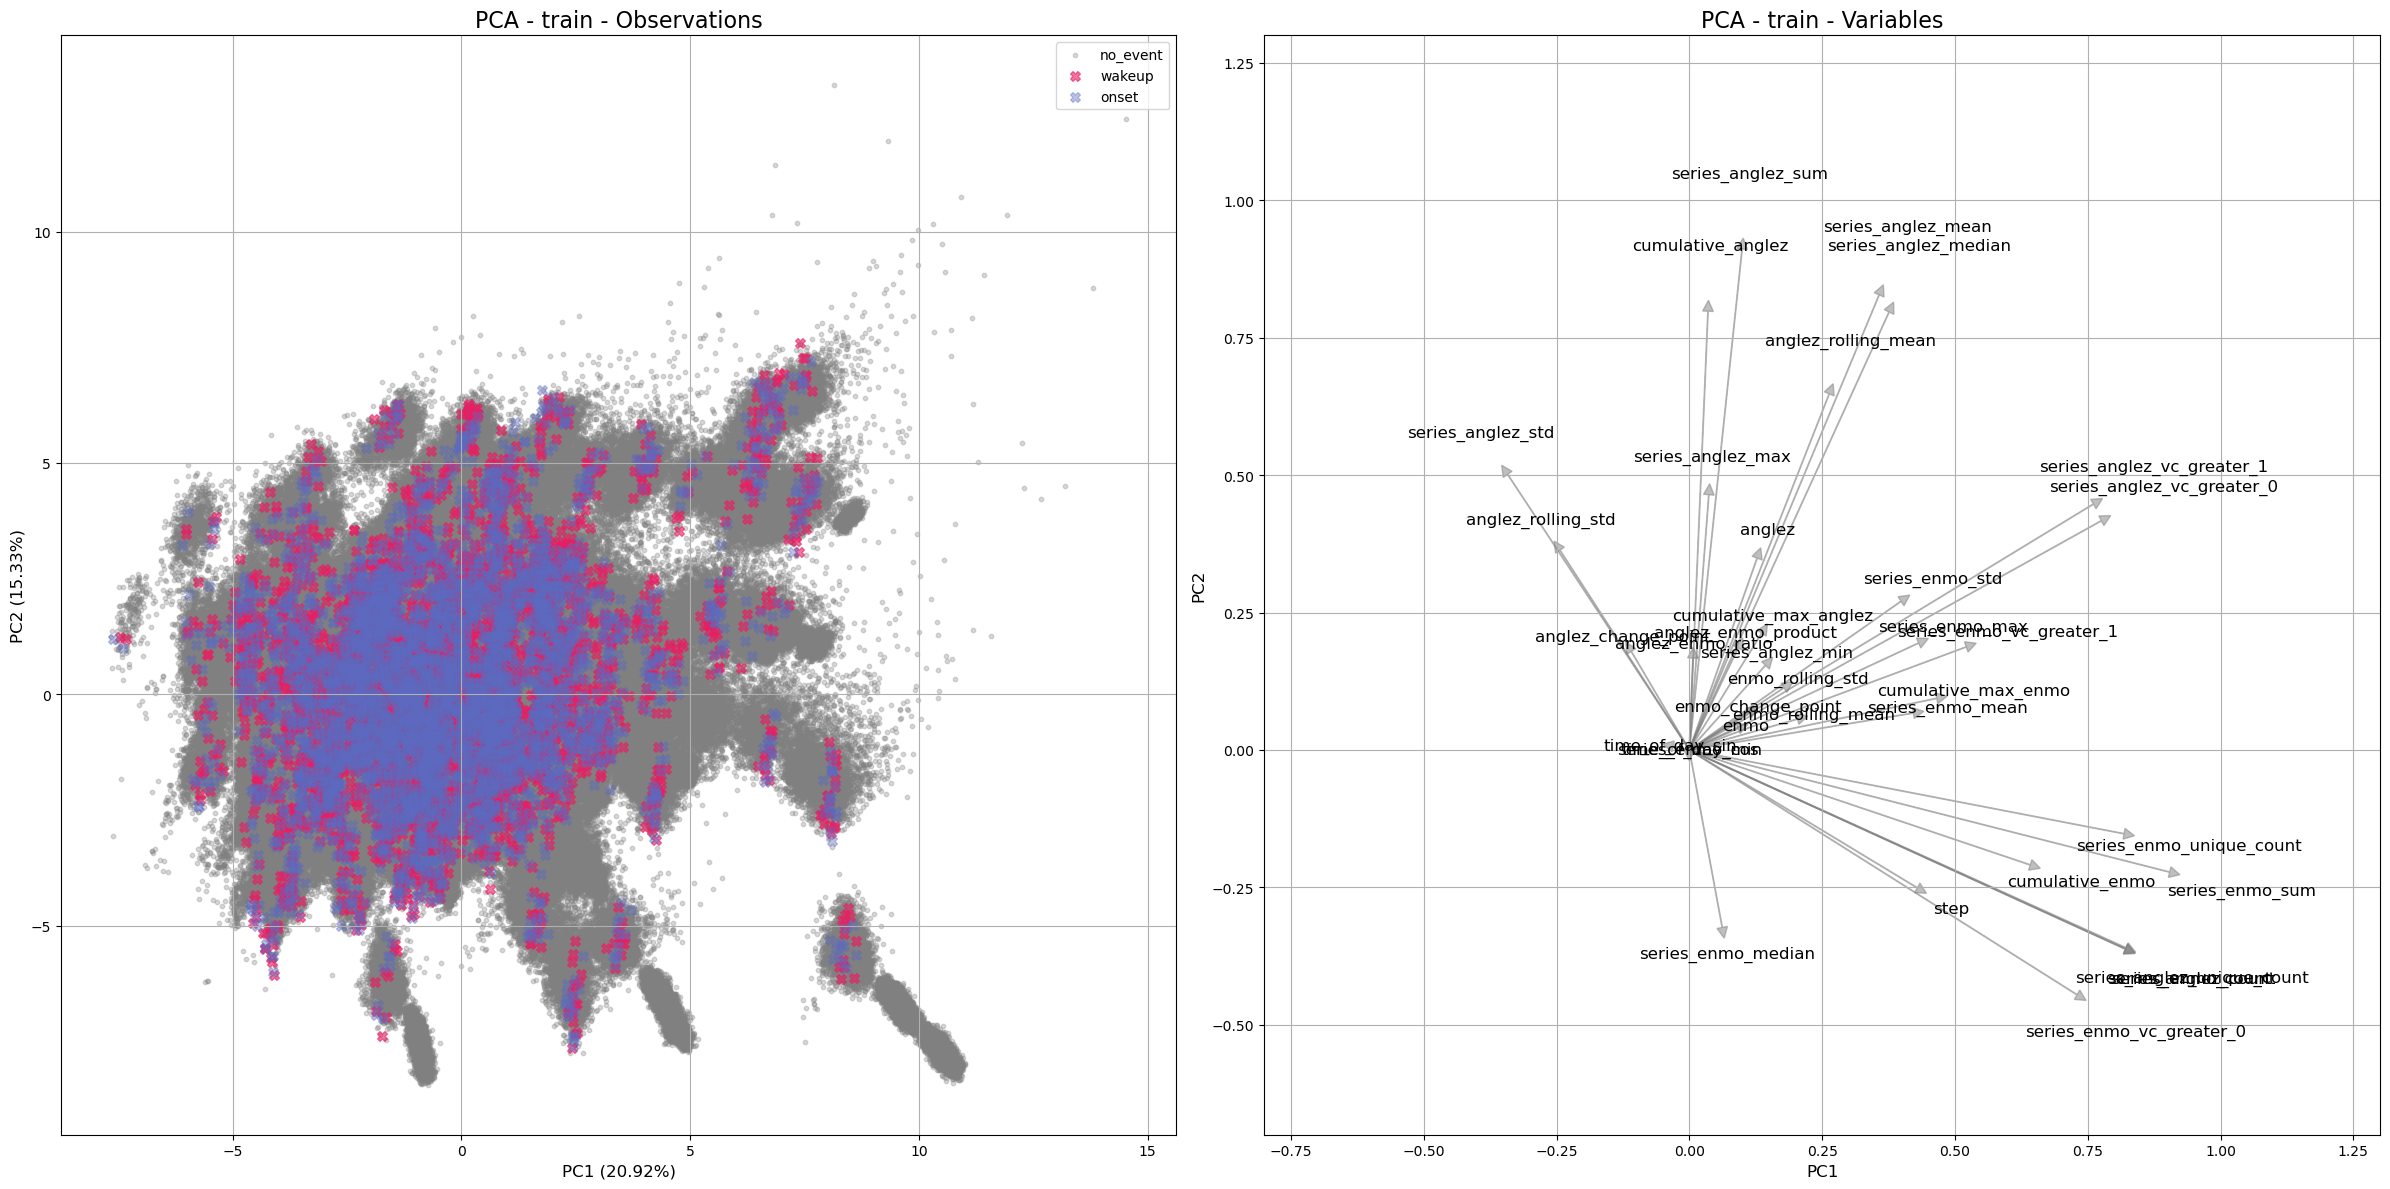

In [85]:
plot_pca(df)

We can see that the first two components of the PCA explain 36% of the variance.Taking into account the complexity of the data, no doubts that the linear transformation of the data, such as PCA, is not enough to capture its complexity. Therefore, it is not very surprising that the first two components of the PCA do not show a clear separation between the different sleep states. We will need to use more complex models to be able to distinguish between the different sleep states.